Chinese Dish Classifier
-----------------------
Yuandong Zhang

Structure
---------
- Image Segmentation
  - Binarization and Inversion
  - Otsu Thresholding
  - Contour Metadata Analysis
  - Demonstration
  - Segmentation using Encapsulated API
- Color Distribution
- Local Binary Pattern
- Bag of Visual Words (BoVW)
- Model Training
  - Random Forest (RF)
    - RF with Color + BoVW
    - RF with Color
    - RF with BoVW
  - Support Vector Machine (SVM)
    - SVM with Color + BoVW
    - SVM with Color
    - SVM with BoVW
  - Deep Neural Network (DNN)
    - DNN with Color + BoVW
    - DNN with Color
    - DNN with BoVW
  - Pre-trained Convolutional Neural Network (CNN) with Image


In [6]:
from skimage.io import imread, imsave   
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import color
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
import cv2
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.models import Model


***Image Segmentation***

In [2]:
from skimage import filters
import skimage.measure as measure
from tqdm import tqdm
import glob
from data_tools import segment_images, find_contours
import pandas as pd 

In [3]:
image = cv2.imread("images/dishes/IMG_8874.JPG")

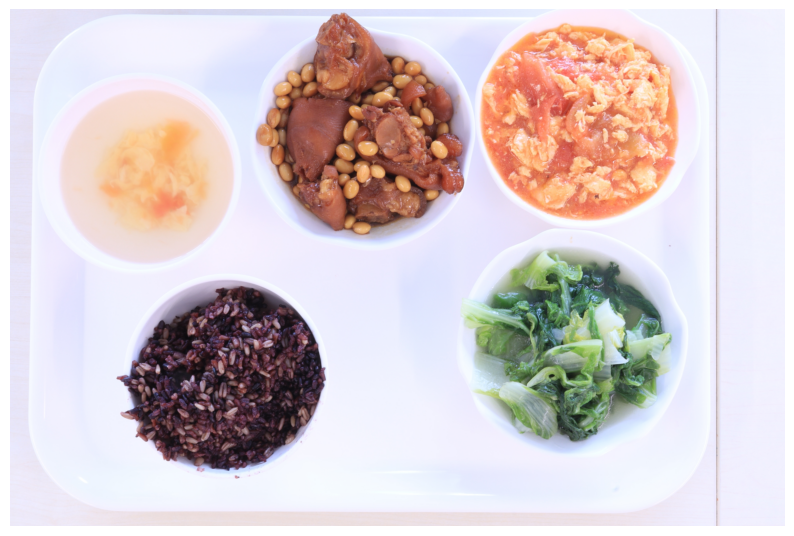

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# show with RGB
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax.axis('off')  
plt.show()


**Binarization and Inversion**

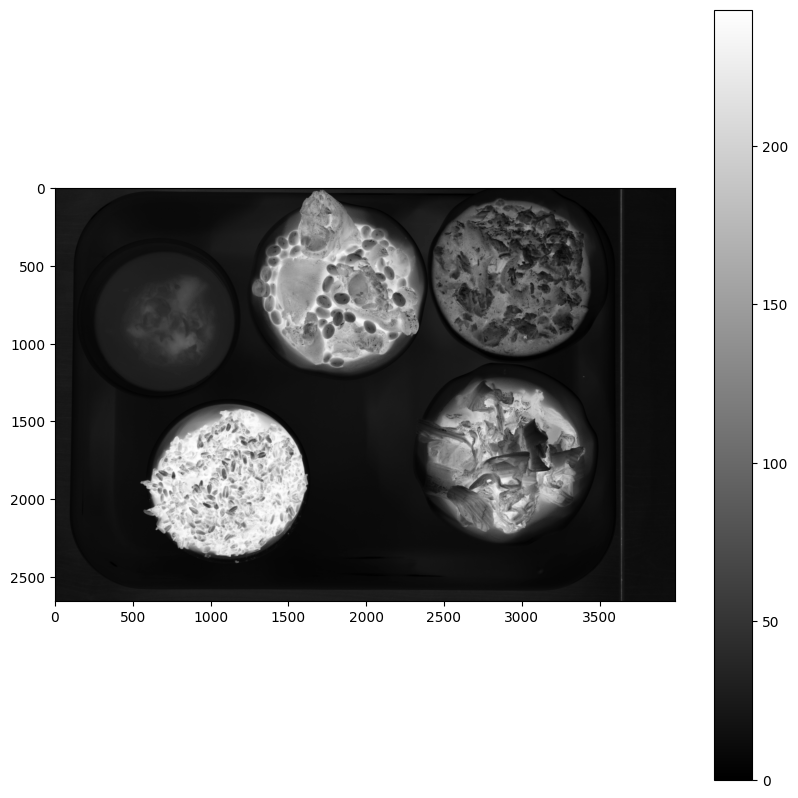

In [5]:
image = cv2.GaussianBlur(image, (5, 5), 0)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # convert to grayscale
# invert the image
gray_image = cv2.bitwise_not(gray_image)
gray_image = gray_image.astype(float)

# show image
plt.figure(figsize=(10, 10))
plt.imshow(gray_image, cmap='gray')
# show gray scale colorbar
plt.colorbar()
plt.axis('on')
plt.show()

**OTSU Thresholding**

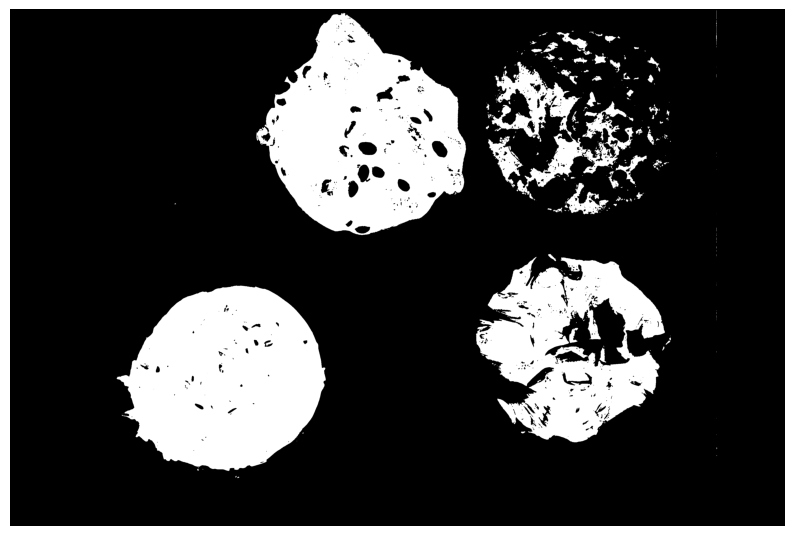

In [6]:
# try otsu's method
threshold = filters.threshold_otsu(gray_image)
bina_otsu = gray_image > threshold

# plot the image
plt.figure(figsize=(10, 10))
plt.imshow(bina_otsu, cmap='gray')
plt.axis('off')
plt.show()

**CLOSING AND OPENING**

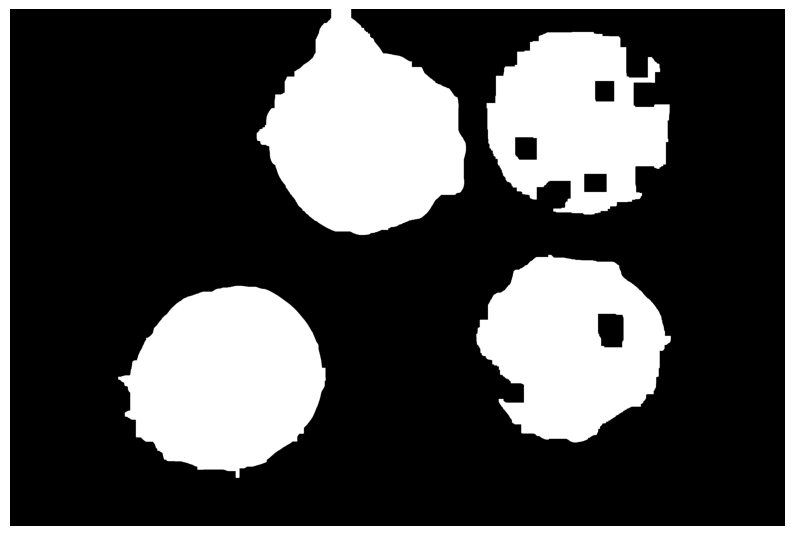

In [7]:
# use closing and opening to remove noise
from cv2 import morphologyEx
# i want all the holes to be filled with a big kernel
kernel = np.ones((90,90), np.uint8)
closing = morphologyEx(bina_otsu.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
# i want all the small noise to be removed with a small kernel
kernel = np.ones((15, 15), np.uint8)
opening = morphologyEx(closing, cv2.MORPH_OPEN, kernel)
# plot the image
plt.figure(figsize=(10, 10))
plt.imshow(opening, cmap='gray')
plt.axis('off')
plt.show()

**Contour Metadata Analysis**

100%|██████████| 162/162 [00:51<00:00,  3.12it/s]


Image 8923 has the most contours: 19
      Length         Area                                           Contours
17  689833.0  3395.606328  [[[1797, 346]], [[1796, 347]], [[1794, 347]], ...
7    79239.5  1878.256920  [[[2399, 1001]], [[2399, 1031]], [[2400, 1032]...
2   121436.5  1604.648836  [[[2467, 1762]], [[2467, 1763]], [[2465, 1765]...
5    27574.5   982.859952  [[[1680, 1452]], [[1680, 1466]], [[1682, 1468]...
9    31474.0   813.102593  [[[0, 743]], [[0, 1064]], [[11, 1064]], [[13, ...
6    10677.5   784.409161  [[[1403, 1381]], [[1401, 1383]], [[1399, 1383]...
8    11838.0   641.656854  [[[2503, 785]], [[2503, 830]], [[2504, 830]], ...
11   12014.0   583.112698  [[[2777, 714]], [[2777, 755]], [[2776, 756]], ...
0     7659.0   382.828427  [[[1640, 1929]], [[1640, 2022]], [[1725, 2022]...
18    3133.0   314.970562  [[[2109, 0]], [[2109, 18]], [[2112, 21]], [[21...
10    3130.0   253.254834  [[[2967, 725]], [[2965, 727]], [[2963, 727]], ...
3     1919.5   187.899495  [[[1137, 151

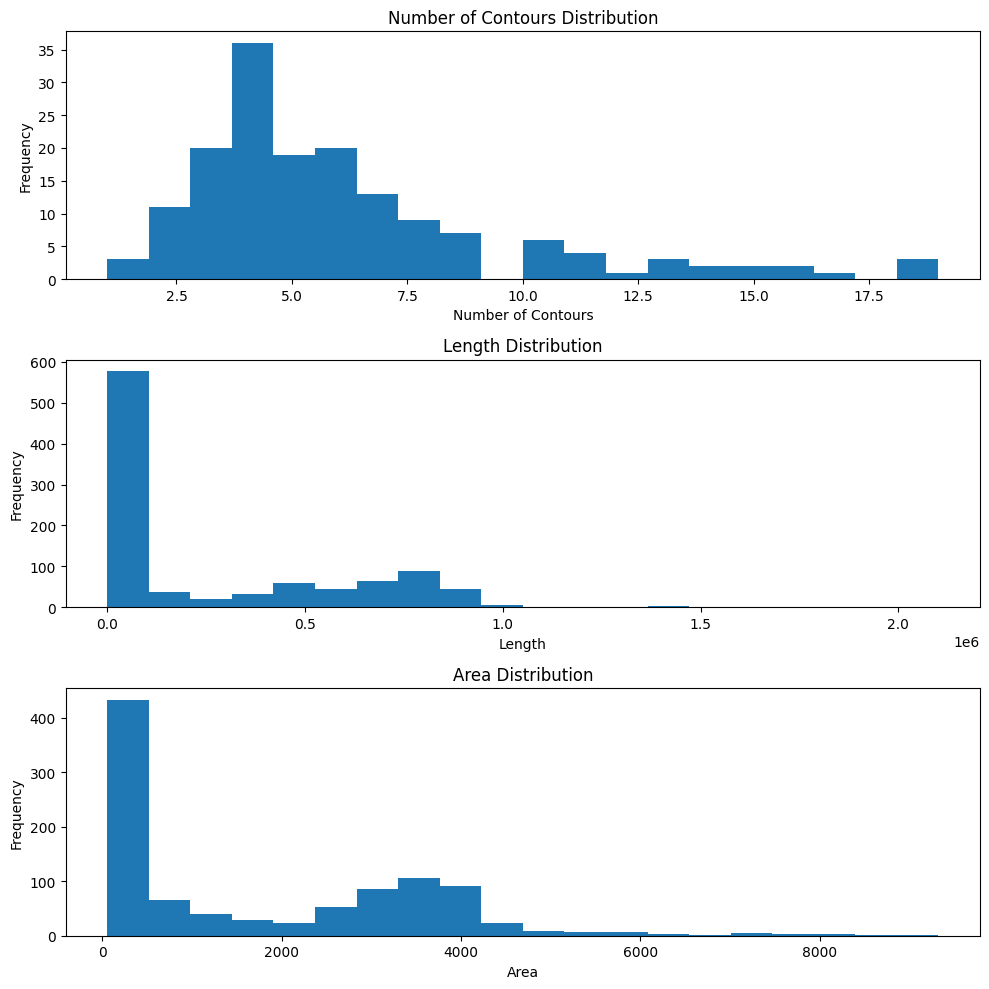

In [8]:
# get all images in the dishes folder
images = glob.glob("images/dishes/*")

# make a dictionary to store the length and area of the contours
info_dict = {}


# use the last 4 digits of the image name as the image number   
for image in tqdm(images):
    image_number = int(image.split("/")[-1].split(".")[0][-4:])
    contour_number,len_area_list,contours = find_contours(image_path = image,kernel_size = (90,90))
    info_dict[image_number] = [contour_number,len_area_list,contours]

    
# find the image with the most contours, plot the contours and show the image
max_contour = 0
max_contour_image = ""
for image_number in info_dict:
    if info_dict[image_number][0] > max_contour:
        max_contour = info_dict[image_number][0]
        max_contour_image = image_number
        max_contour_contours = info_dict[image_number][2]

print(f"Image {max_contour_image} has the most contours: {max_contour}")

# find the entry of the image with the most contours in the dictionary
max_contour_info = info_dict[max_contour_image]

contours = max_contour_info[2]

# print the length and area of the contours
len_area_list = max_contour_info[1]
len_area_df = pd.DataFrame(len_area_list, columns = ["Length","Area","Contours"])
# sort the dataframe by area
len_area_df = len_area_df.sort_values("Area", ascending = False)
# show dataframe using panda
print(len_area_df)

# plot contours and areas distribution histograms in the dictioanry

# plot the histogram of the number of contours
contour_number_list = [info_dict[image][0] for image in info_dict]

length_list = []
for image in info_dict:
    for length, area, _ in info_dict[image][1]:
        length_list.append(length)

area_list = []
for image in info_dict:
    for length, area, _  in info_dict[image][1]:
        area_list.append(area)


# plot three histograms in one figure
fig, axs = plt.subplots(3, 1, figsize = (10,10))
axs[0].hist(contour_number_list, bins = 20)
axs[0].set_title("Number of Contours Distribution")
axs[0].set_xlabel("Number of Contours")
axs[0].set_ylabel("Frequency")

axs[1].hist(length_list, bins = 20)
axs[1].set_title("Length Distribution")
axs[1].set_xlabel("Length")
axs[1].set_ylabel("Frequency")

axs[2].hist(area_list, bins = 20)
axs[2].set_title("Area Distribution")
axs[2].set_xlabel("Area")
axs[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()




**Demonstration**

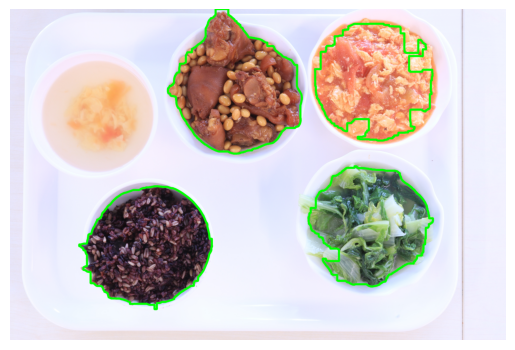

In [9]:
# for demonstration
num, len_area_list, contours = find_contours("images/dishes/IMG_8874.JPG")
# define lower and upper bounds for length and area
lower_length = 300000
upper_length = 900000
lower_area = 2000
upper_area = 5000
len_area_df = pd.DataFrame(len_area_list, columns = ["Length","Area","Contour"])
filtered_df = len_area_df[(len_area_df["Length"] > lower_length) & (len_area_df["Length"] < upper_length) & (len_area_df["Area"] > lower_area) & (len_area_df["Area"] < upper_area)]
filtered_contours = []
for i in filtered_df.index:
    filtered_contours.append(contours[i])

image = cv2.imread("images/dishes/IMG_8874.JPG")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.drawContours(image, filtered_contours, -1, (0, 255, 0), 15)
plt.imshow(image)
plt.axis("off")
plt.show()

# this is used for actual segmentation 
#     segment_images(image_path = image_path, save_path = save_path, 
                #    save_index = image_number, length_thres_low=300000, 
                #    length_thres_high=900000, area_thres_low=2000, 
                #    area_thres_high=5000,kernel_size=(90,90))


**Segmentation Using Encapsulated API**

In [ ]:
images = glob.glob("images/dishes/*")


save_path = "image_classification/images/segmented_dishes"
for image in tqdm(images):
    image_number = int(image.split("/")[-1].split(".")[0][-4:])
    image_path = image
    segment_images(image_path = image_path, save_path = save_path, 
                   save_index = image_number, length_thres_low=300000, 
                   length_thres_high=900000, area_thres_low=2000, 
                   area_thres_high=5000,kernel_size=(90,90))

***Color Distribution***

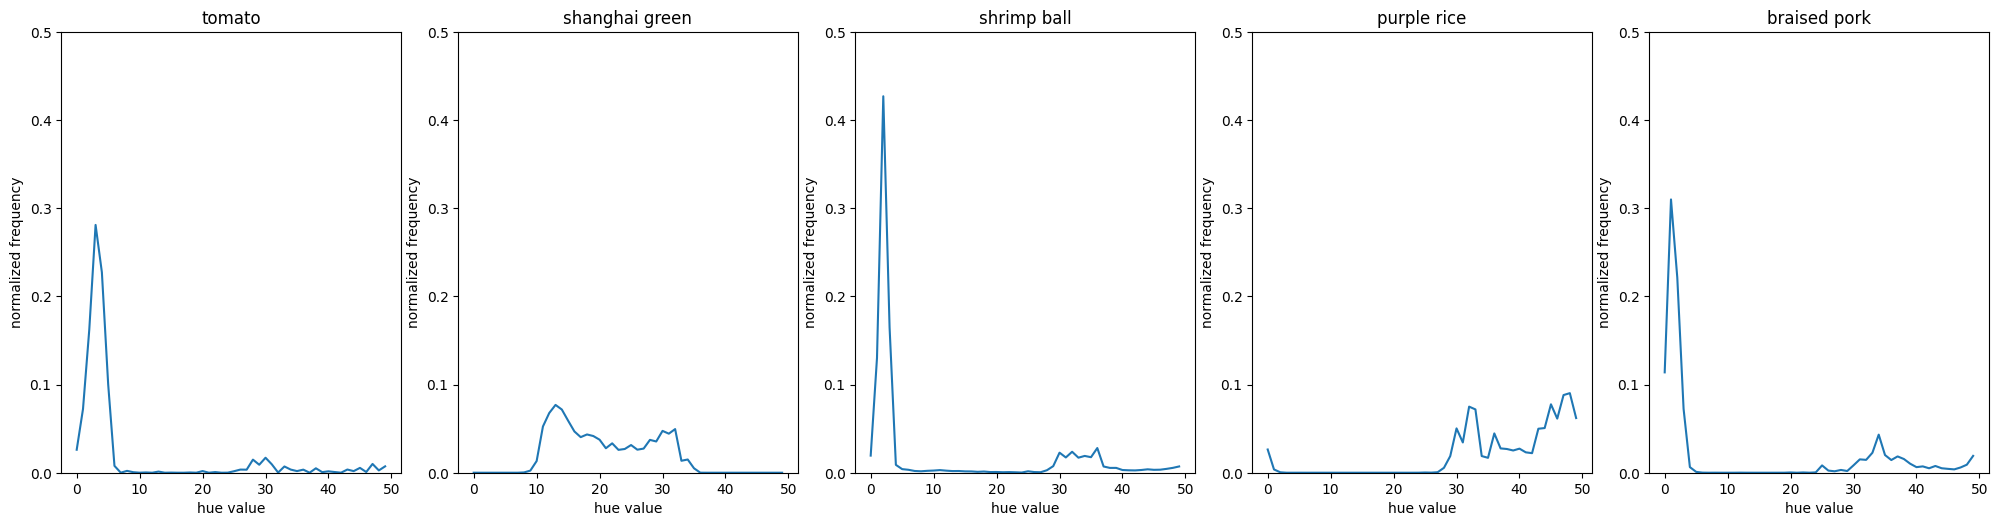

In [4]:
import matplotlib.pyplot as plt
import cv2
from skimage import color
import numpy as np

tomato_egg = cv2.imread('/Users/taojing/Desktop/image_classification/images/segmented_dishes/tomato_egg/segmented_dish_9642_0.jpg')
# tomato = tomato_egg.astype(np.float32) / 255.0
sh_green = cv2.imread('/Users/taojing/Desktop/image_classification/images/segmented_dishes/shanghai_green/segmented_dish_8874_1.jpg')
# sh_green = sh_green.astype(np.float32) / 255.0
shrimp_ball = cv2.imread('images/segmented_dishes/shirmp_egg/segmented_dish_8894_2.jpg')
# shrimp_ball = shrimp_ball.astype(np.float32) / 255.0
purple_rice = cv2.imread('/Users/taojing/Desktop/image_classification/images/segmented_dishes/purple_rice/segmented_dish_8874_0.jpg')
# purple_rice = purple_rice.astype(np.float32) / 255.0
braised_pork = cv2.imread('/Users/taojing/Desktop/image_classification/images/training_set/hong_shao_rou/segmented_dish_8996_1.jpg')
# braised_pork = braised_pork.astype(np.float32)  / 255.0

# convert all images to rgb
tomato_rgb = cv2.cvtColor(tomato_egg, cv2.COLOR_BGR2RGB)
sh_green_rgb = cv2.cvtColor(sh_green, cv2.COLOR_BGR2RGB)
shrimp_ball_rgb = cv2.cvtColor(shrimp_ball, cv2.COLOR_BGR2RGB)
purple_rice_rgb = cv2.cvtColor(purple_rice, cv2.COLOR_BGR2RGB)
braised_pork_rgb = cv2.cvtColor(braised_pork, cv2.COLOR_BGR2RGB)
# convert to hsv
tomato_hsv = color.rgb2hsv(tomato_rgb)
sh_green_hsv = color.rgb2hsv(sh_green_rgb)
shrimp_ball_hsv = color.rgb2hsv(shrimp_ball_rgb)
purple_rice_hsv = color.rgb2hsv(purple_rice_rgb)
braised_pork_hsv = color.rgb2hsv(braised_pork_rgb)

# compute the histograms of the hue channel
def compute_hue_histogram(image):
    hist,_ = np.histogram(image[:,:,0].ravel(), bins=np.arange(0, 1.01, 0.02))
    # normalize the histogram
    hist = hist/hist.sum()
    return hist

tomato_hue_hist = compute_hue_histogram(tomato_hsv)
sh_green_hue_hist = compute_hue_histogram(sh_green_hsv)
shrimp_ball_hue_hist = compute_hue_histogram(shrimp_ball_hsv)
purple_rice_hue_hist = compute_hue_histogram(purple_rice_hsv)
braised_pork_hue_hist = compute_hue_histogram(braised_pork_hsv)

# plot all the hue histograms in the same plot
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
fig.tight_layout()
ax[0].plot(tomato_hue_hist)
ax[0].set_xlabel('hue value')
ax[0].set_ylabel('normalized frequency')
ax[0].set_title('tomato')
ax[0].set_ylim([0, 0.5])
ax[1].plot(sh_green_hue_hist) 
ax[1].set_xlabel('hue value')
ax[1].set_ylabel('normalized frequency')
ax[1].set_title('shanghai green')
ax[1].set_ylim([0, 0.5])
ax[2].plot(shrimp_ball_hue_hist)
ax[2].set_xlabel('hue value')
ax[2].set_ylabel('normalized frequency')
ax[2].set_title('shrimp ball')
ax[2].set_ylim([0, 0.5])
ax[3].plot(purple_rice_hue_hist)
ax[3].set_ylim([0, 0.5])
ax[3].set_xlabel('hue value')
ax[3].set_ylabel('normalized frequency')

ax[3].set_title('purple rice')
ax[4].plot(braised_pork_hue_hist)
ax[4].set_ylim([0, 0.5])
ax[4].set_xlabel('hue value')
ax[4].set_ylabel('normalized frequency')
ax[4].set_title('braised pork')

plt.show()






***Local Binary Pattern***

In [5]:
# compute local binary pattern for all five images
from skimage.feature import local_binary_pattern    
def compute_lbp(image):
    lbp = local_binary_pattern(image, 8, 1, 'uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=50, range=(0, 59))
    return lbp, hist

tomato_lbp, tomato_lbp_hist = compute_lbp(cv2.cvtColor(tomato_egg, cv2.COLOR_BGR2GRAY))
sh_green_lbp, sh_green_lbp_hist = compute_lbp(cv2.cvtColor(sh_green, cv2.COLOR_BGR2GRAY))
shrimp_ball_lbp, shrimp_ball_lbp_hist = compute_lbp(cv2.cvtColor(shrimp_ball, cv2.COLOR_BGR2GRAY))
purple_rice_lbp, purple_rice_lbp_hist = compute_lbp(cv2.cvtColor(purple_rice, cv2.COLOR_BGR2GRAY))
braised_pork_lbp, braised_pork_lbp_hist = compute_lbp(cv2.cvtColor(braised_pork, cv2.COLOR_BGR2GRAY))



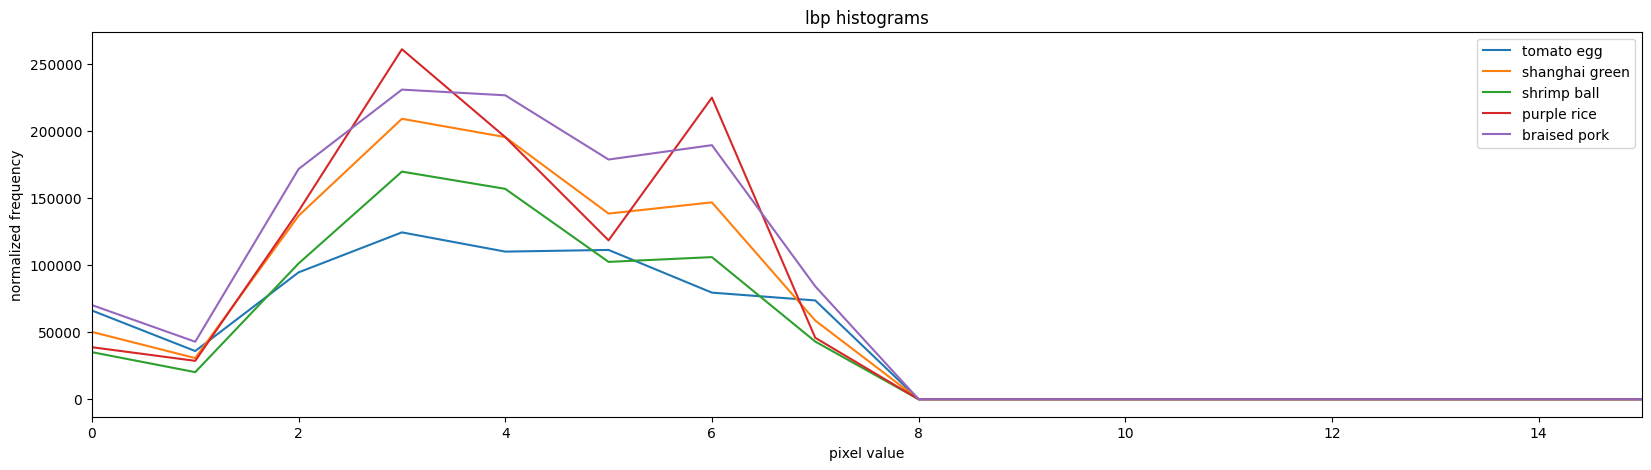

In [6]:
# plot lbp histograms in one figure
figure = plt.figure(figsize=(20, 5))
plt.plot(tomato_lbp_hist, label='tomato egg')
plt.plot(sh_green_lbp_hist, label='shanghai green')
plt.plot(shrimp_ball_lbp_hist, label='shrimp ball')
plt.plot(purple_rice_lbp_hist, label='purple rice')
plt.plot(braised_pork_lbp_hist, label='braised pork')
plt.xlabel('pixel value')
plt.ylabel('normalized frequency')
plt.title('lbp histograms')
plt.xlim([0, 15])
plt.legend()
plt.show()


***BoVW***
- visualizing BoVW histograms seems lack of semantic context, so only demonstrating the code in the pipeline here

In [7]:
# the code is defined in extraction_tools.py
def extract_sift_features(training_set):
    # Extract SIFT features from the training set
    descriptor = cv2.SIFT_create()
    # extract keypoints from each image
    training_set['keypoints'] = []
    training_set['descriptors'] = []

    for img in training_set['data']:
        gray = np.uint8(color.rgb2gray(img)*255)
        kp, des = descriptor.detectAndCompute(gray, None)
        training_set['keypoints'].append(kp)
        training_set['descriptors'].append(des)
    return training_set
        

def extract_bag_of_sift(training_set, k = 50, batch_size = 100):

        # initiate a MiniBatchKMeans object
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)

        # concatenate all descriptors into a single array
        all_descriptors = np.concatenate(training_set['descriptors'])

        # fit the kmeans model
        kmeans.fit(all_descriptors)
        training_set['histograms'] = []


        for des in training_set['descriptors']:
            # predict the cluster index for each descriptor
            clusters = kmeans.predict(des)
            # compute the histogram
            hist, _ = np.histogram(clusters, bins=np.arange(k+1))

            training_set['histograms'].append(hist)
    

        return training_set


***MODEL TRAINING***

In [1]:
from data_tools import load_dataset
from extraction_tools import extract_sift_features,extract_bag_of_sift,extract_color_histograms,split_dataset
import matplotlib.pyplot as plt

In [2]:
training_set = load_dataset()

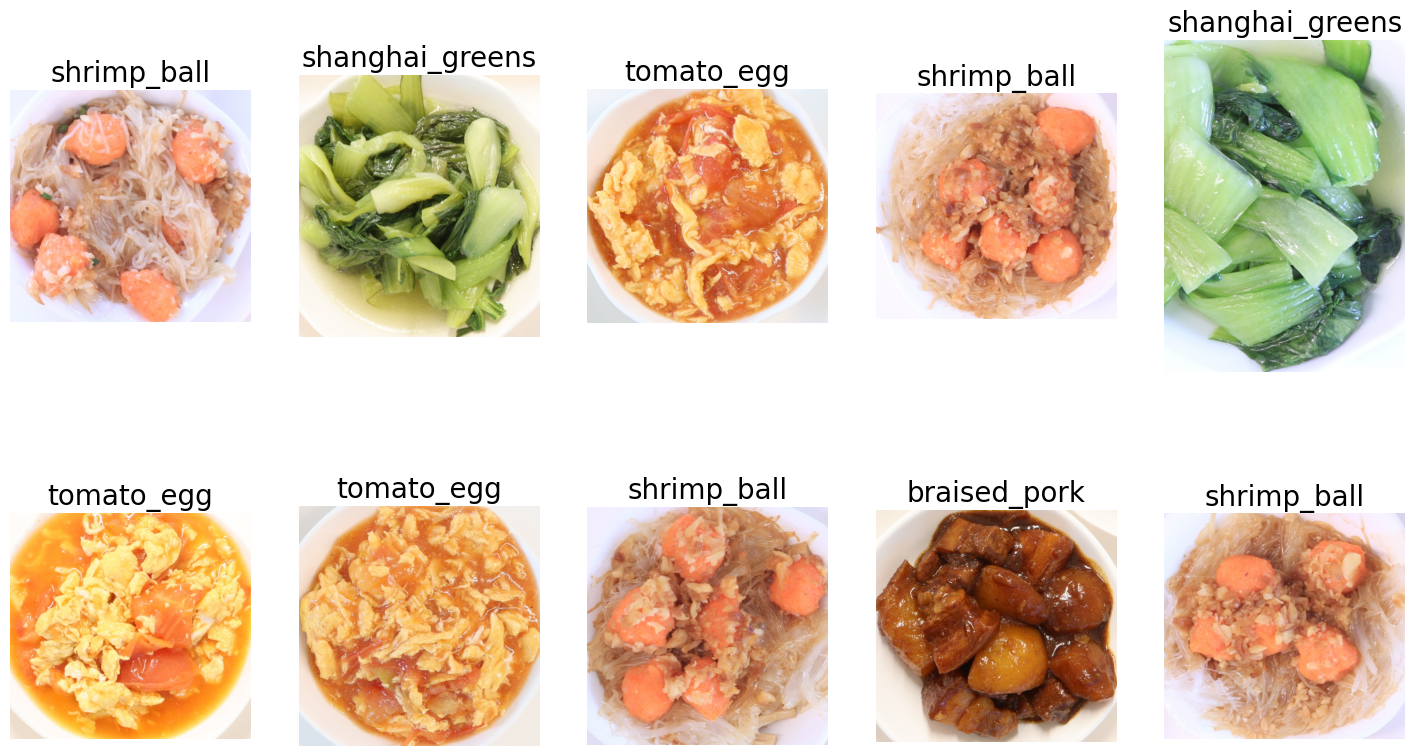

In [54]:
plt.figure(figsize=(18,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(training_set['data'][i])
    plt.axis('off')
    plt.title(training_set['label'][i], fontsize=20)
plt.show()


In [5]:
# define confusion matrix labels, convert numerical labels to string labels
confusion_matrix_labels = ['tomato_egg', 'braised_pork', 'purple_rice', 'shanghai_greens', 'shrimp_ball']

In [3]:
training_set = extract_sift_features(training_set)
training_set = extract_bag_of_sift(training_set) 
training_set = extract_color_histograms(training_set)
X_train, X_test, y_train, y_test = split_dataset(training_set)     

In [7]:
print(training_set['color_histograms'][0].shape)
print(training_set['histograms'][0].shape)

(50,)
(50,)


**RF with Color + BoVW**

In [11]:
# train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# evaluate the classifier
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)


accuracy: 0.96


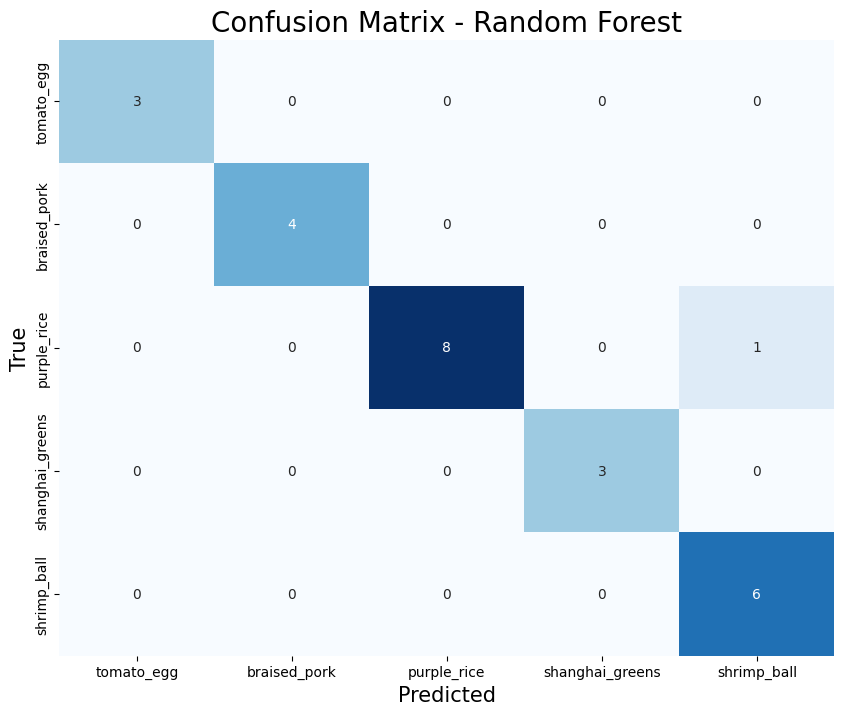

In [12]:
# show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix - Random Forest', fontsize=20)
plt.show()


**RF with concat features**

accuracy: 0.96


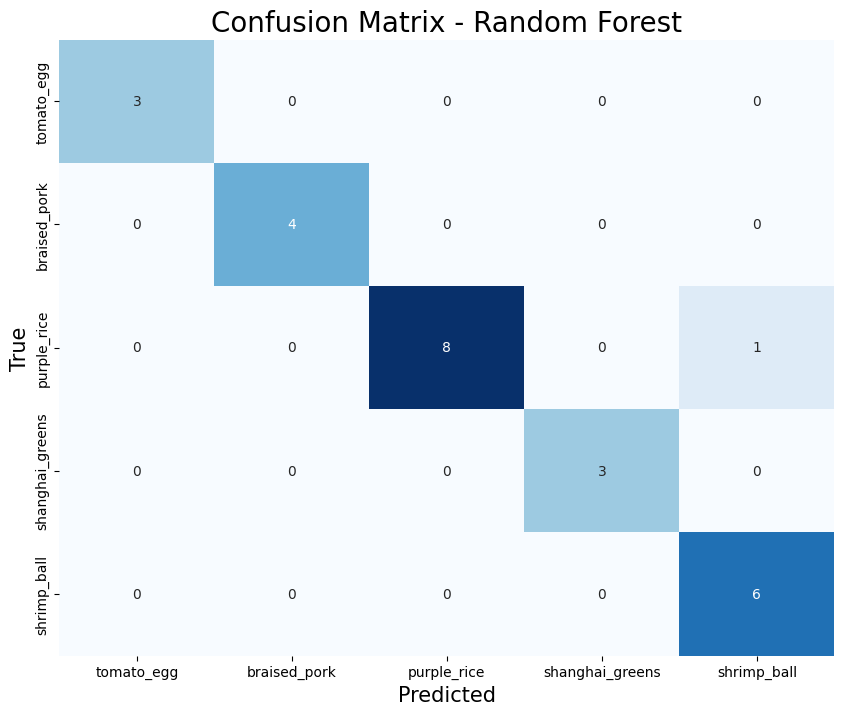

In [21]:
X = np.hstack((training_set['histograms'], training_set['color_histograms']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# random forest classifier
clf4 = RandomForestClassifier(n_estimators=100, random_state=42)
clf4.fit(X_train, y_train)
y_pred = clf4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)

# show the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)

plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix - Random Forest', fontsize=20)
plt.show()




**RF with Color Features**

In [13]:
# a random forest with just color features
from sklearn.model_selection import train_test_split
X = training_set['color_histograms']
y = training_set['label']

50
accuracy: 0.96


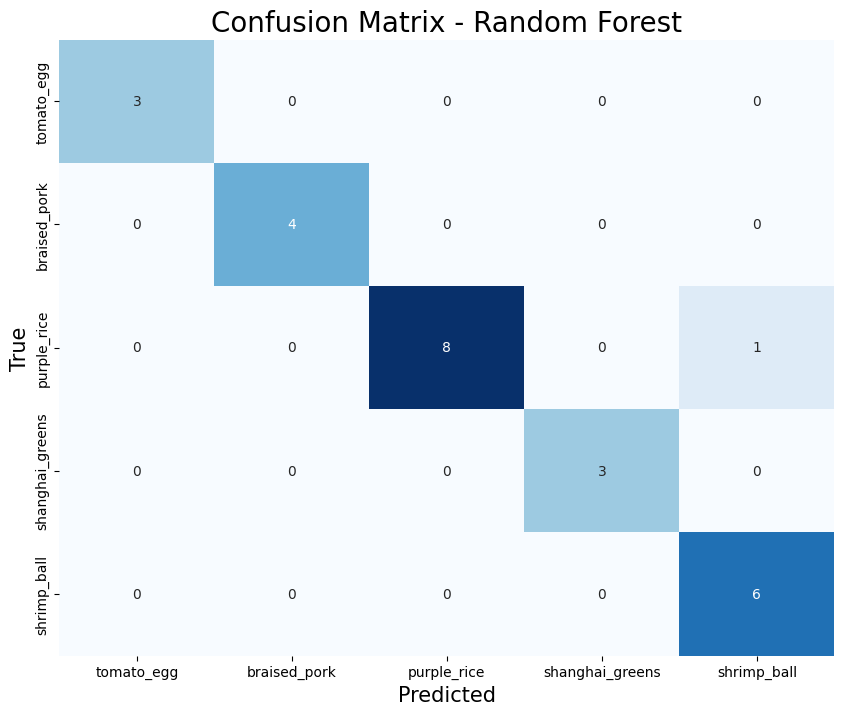

In [14]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train[0]))
# train a random forest classifier
clf2 = RandomForestClassifier(n_estimators=100,random_state=42)
clf2.fit(X_train, y_train)

# evaluate the classifier
y_pred = clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)

# show the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix - Random Forest', fontsize=20)
plt.show()


**RF with BoVW**

50
accuracy: 0.88


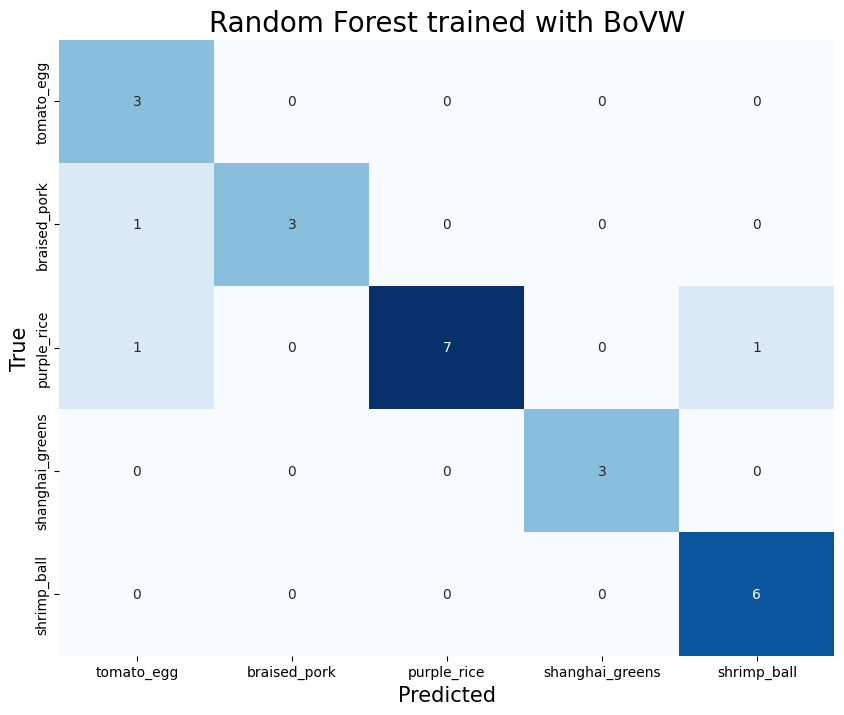

In [48]:
# train a random forest with just bag of sift features
X = training_set['histograms']
y = training_set['label']

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train[0]))
# train a random forest classifier
clf3 = RandomForestClassifier(n_estimators=100,random_state=42)
clf3.fit(X_train, y_train)

# evaluate the classifier
y_pred = clf3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)

# show the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Random Forest trained with BoVW', fontsize=20)
plt.show()


**SVM with Color + BoVW**

accuracy: 1.0


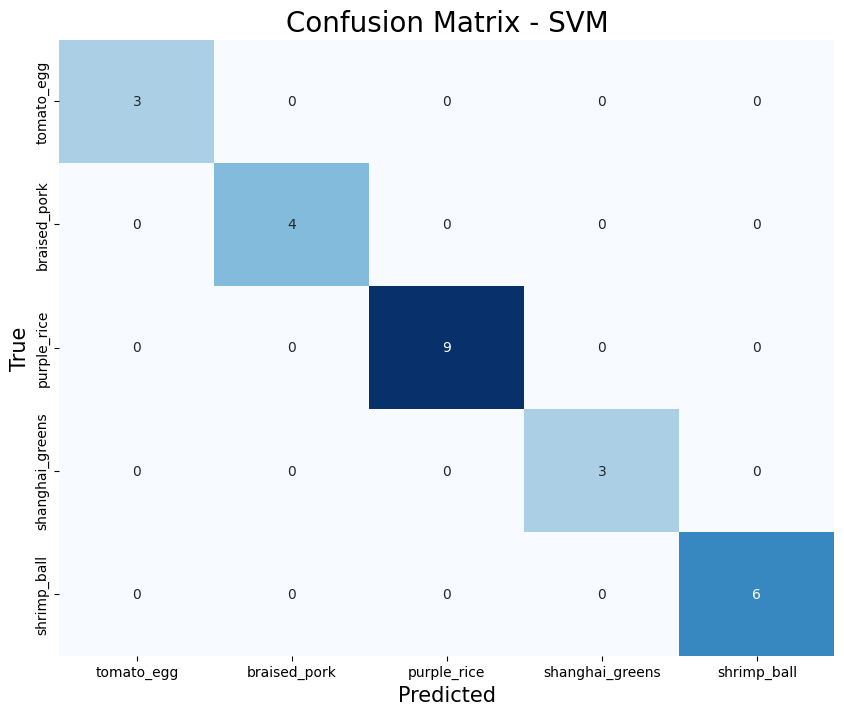

In [16]:
#  train a SVM
from sklearn.svm import SVC
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)

# show the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix - SVM', fontsize=20)
plt.show()


**Non-Linear SVM with Concat Features**

accuracy: 0.88


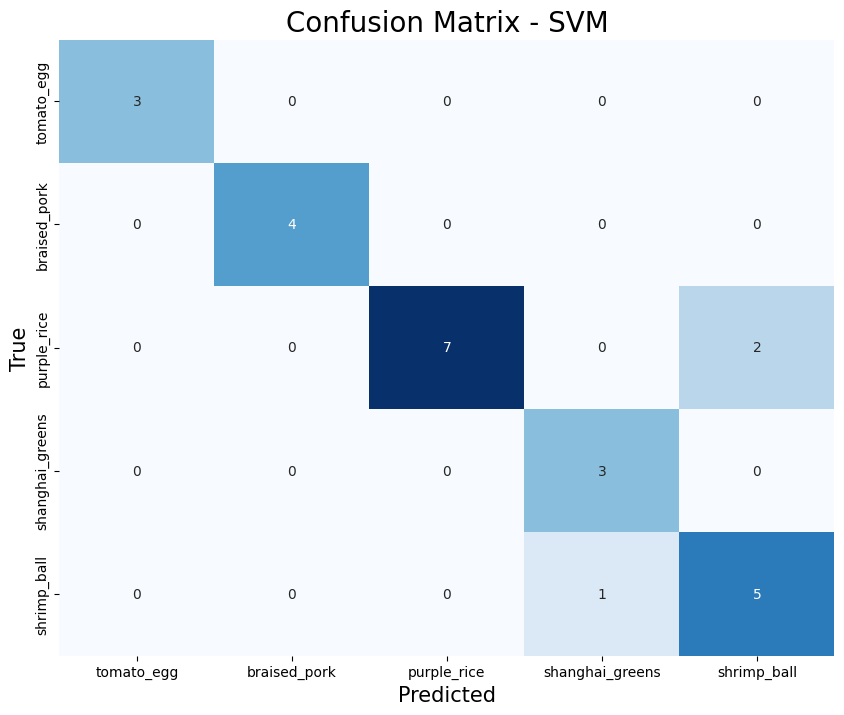

In [45]:
# stack the feature and train a non-linear SVM
X = np.hstack((training_set['histograms'], training_set['color_histograms']))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='rbf', random_state=42)
clf.fit(X_train, y_train)

# evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)

# show the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Confusion Matrix - SVM', fontsize=20)
plt.show()



**SVM with Color**

accuracy: 0.84


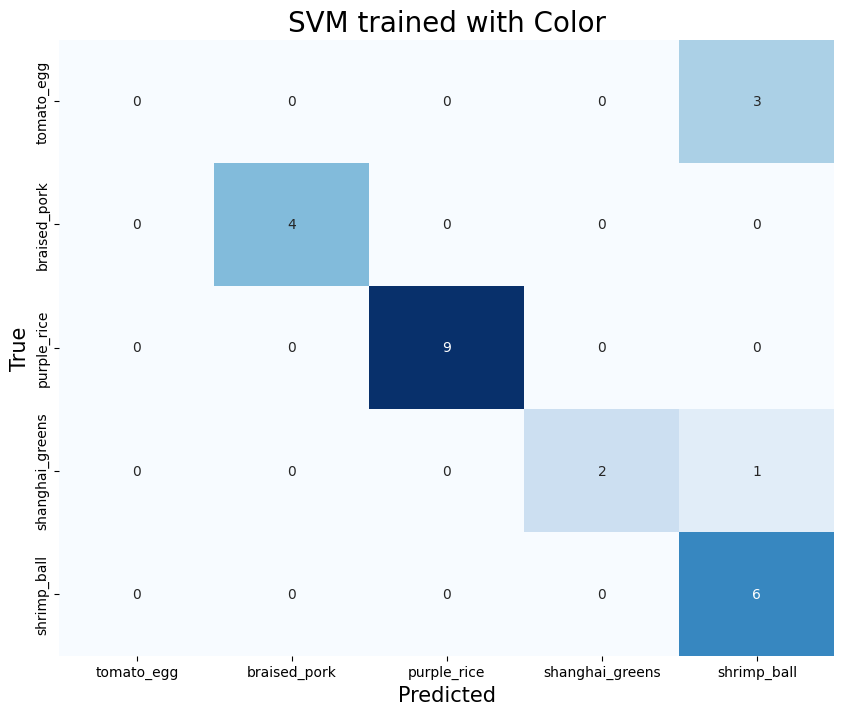

In [44]:
# try only using color features train SVM
X = training_set['color_histograms']
y = training_set['label']

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy:', accuracy)

# show confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)

plt.title('SVM trained with Color', fontsize=20)
plt.show()


**SVM with BoVW**

accuracy: 1.0


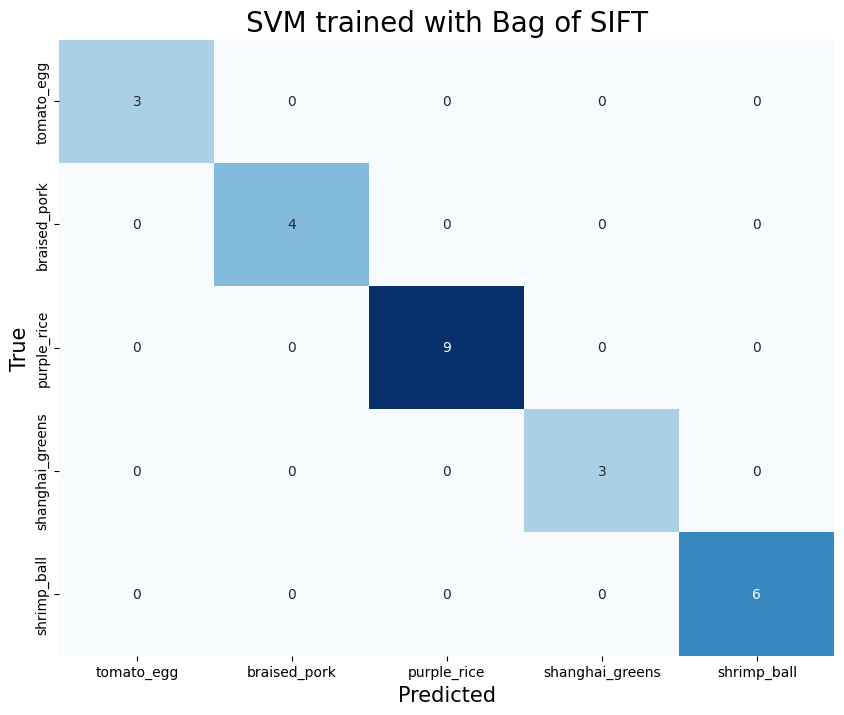

In [47]:
# try only using bag of sift features train SVM

X = training_set['histograms']
y = training_set['label']

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# evaluate the classifier

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('accuracy:', accuracy)

# show confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=confusion_matrix_labels, yticklabels=confusion_matrix_labels, cbar=False)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('SVM trained with Bag of SIFT', fontsize=20)
plt.show()


**Pretrained CNN with Image**

In [22]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(5, activation='softmax')(x)

# Create a new model
model = Model(inputs=base_model.input, outputs=x)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('images/training_set', target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory('images/validation_set', target_size=(224, 224), batch_size=32, class_mode='categorical')

# implement early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping])

Found 122 images belonging to 5 classes.
Found 108 images belonging to 5 classes.
Epoch 1/50


/Users/taojing/miniconda3/envs/cs302/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1095 - loss: 2.3368 - val_accuracy: 0.1574 - val_loss: 2.2092
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1554 - loss: 2.1922 - val_accuracy: 0.1574 - val_loss: 2.0683
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1181 - loss: 2.1743 - val_accuracy: 0.1667 - val_loss: 2.0383
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1023 - loss: 2.0325 - val_accuracy: 0.1944 - val_loss: 1.8924
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1187 - loss: 1.9124 - val_accuracy: 0.2130 - val_loss: 1.8540
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1796 - loss: 1.7971 - val_accuracy: 0.2593 - val_loss: 1.7401
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1706 - loss: 1.6897 - val_accuracy: 0.2870 - val_loss: 1.6082
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1995 - loss: 1.6076 - val_accuracy: 0.3241 - val_loss: 1.5367
Epoch 9/50
4/4 ━━━━━━━━━━━

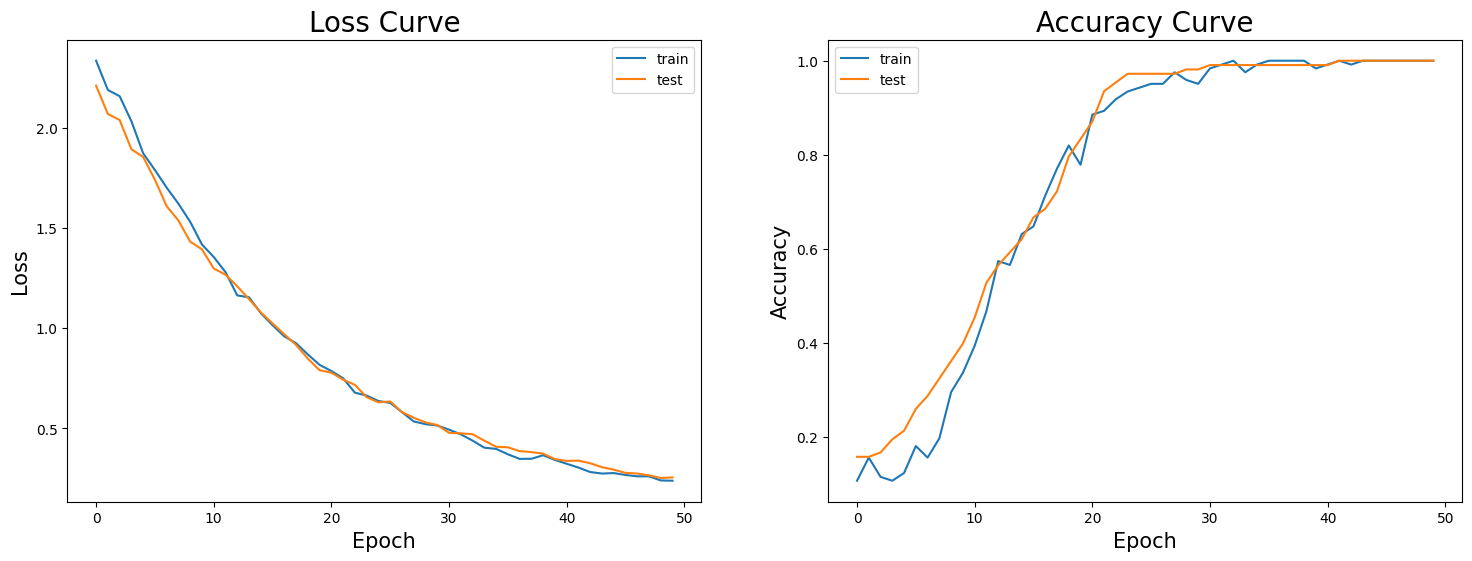

In [23]:
# show the loss curve and accuracy curve
fig, ax = plt.subplots(1,2, figsize=(18,6))

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].set_title('Loss Curve', fontsize=20)
ax[0].set_xlabel('Epoch', fontsize=15)
ax[0].set_ylabel('Loss', fontsize=15)
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='test')
ax[1].set_title('Accuracy Curve', fontsize=20)
ax[1].set_xlabel('Epoch', fontsize=15)
ax[1].set_ylabel('Accuracy', fontsize=15)

ax[1].legend()
plt.show()



In [24]:
X_train, X_test, y_train, y_test = split_dataset(training_set)

In [27]:
# design mapping from string labels to numerical labels
label_mapping = {label: i for i, label in enumerate(confusion_matrix_labels)}

In [28]:
# convert y_train and y_test
y_train = [label_mapping[label] for label in y_train]
y_test = [label_mapping[label] for label in y_test]

In [29]:
# convert to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


**DNN with Color+BoVW**

In [30]:
# train a DNN with feature vectors as input
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)





Epoch 1/50


/Users/taojing/miniconda3/envs/cs302/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1806 - loss: 37.5899 - val_accuracy: 0.6400 - val_loss: 2.7885
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3205 - loss: 23.8487 - val_accuracy: 0.6400 - val_loss: 5.7620
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4522 - loss: 18.7271 - val_accuracy: 0.7200 - val_loss: 3.6524
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4760 - loss: 12.2571 - val_accuracy: 0.6800 - val_loss: 3.2609
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5643 - loss: 11.0816 - val_accuracy: 0.8400 - val_loss: 2.6775
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4760 - loss: 16.9634 - val_accuracy: 0.8800 - val_loss: 1.4830
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6297 - loss: 6.5242 - val_accuracy: 0.9200 - val_loss: 0.6661
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6889 - loss: 5.4715 - val_accuracy: 0.8800 - val_loss: 1.1739
Epoch 9/50
4

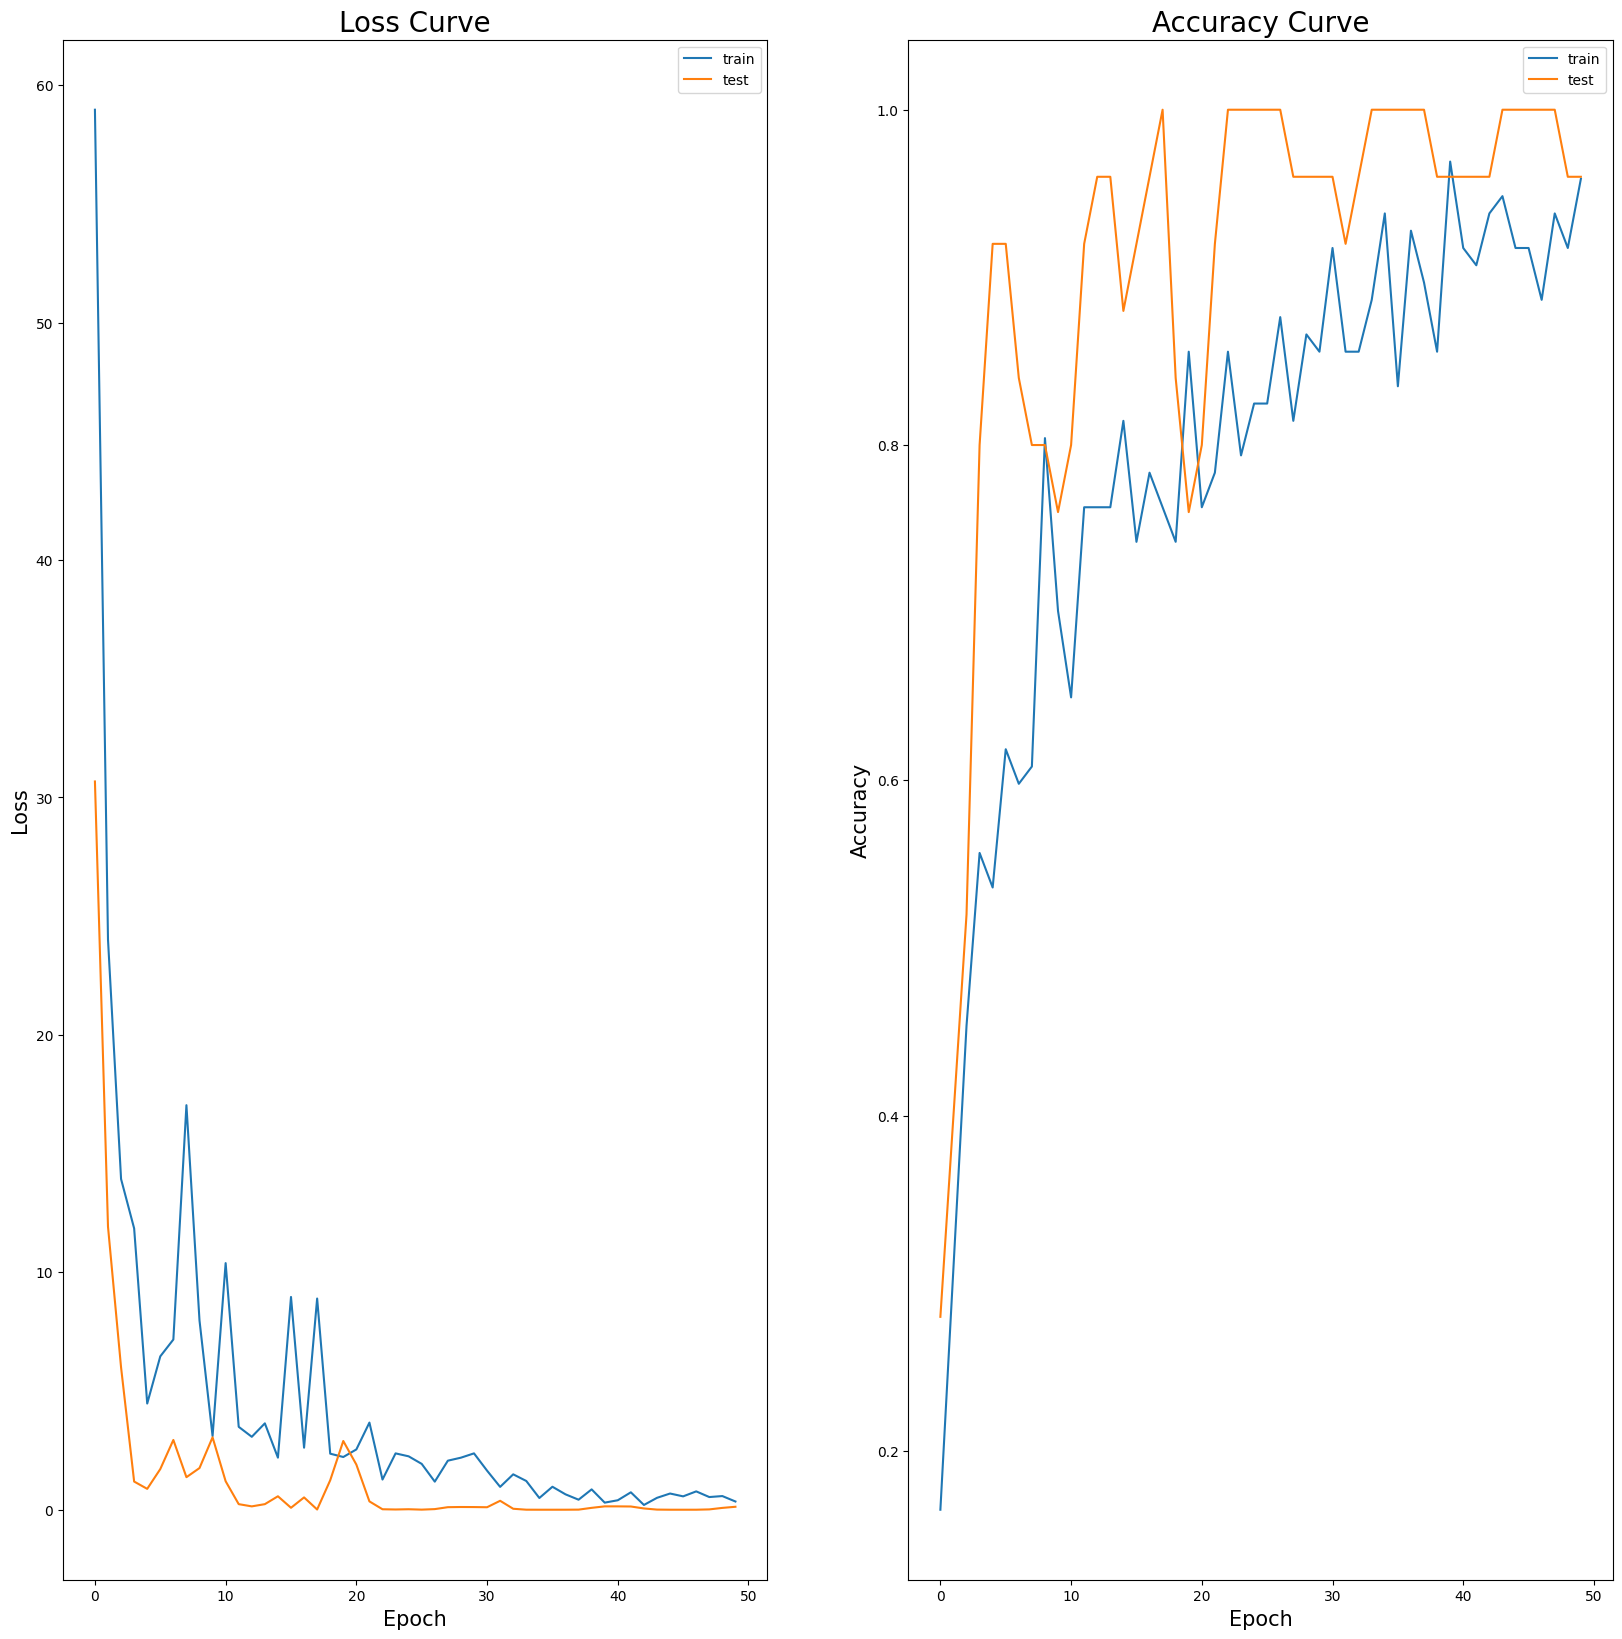

In [42]:
# plot loss and accuracy curve
fig, ax = plt.subplots(1,2, figsize=(20,20))

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].set_title('Loss Curve', fontsize=20)
ax[0].set_xlabel('Epoch', fontsize=15)
ax[0].set_ylabel('Loss', fontsize=15)
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='test')
ax[1].set_title('Accuracy Curve', fontsize=20)
ax[1].set_xlabel('Epoch', fontsize=15)

ax[1].set_ylabel('Accuracy', fontsize=15)

ax[1].legend()

plt.show()



In [31]:
# print accuracy
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print('accuracy:', accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
accuracy: 0.96


**DNN with Color**

In [33]:
# try only using color histograms
X = training_set['color_histograms']
y = training_set['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# convert to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)


y_train = [label_mapping[label] for label in y_train]
y_test = [label_mapping[label] for label in y_test]
                 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)



Epoch 1/50


/Users/taojing/miniconda3/envs/cs302/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3058 - loss: 1.5920 - val_accuracy: 0.7200 - val_loss: 1.5482
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6691 - loss: 1.5471 - val_accuracy: 0.8000 - val_loss: 1.4934
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6701 - loss: 1.4795 - val_accuracy: 0.8400 - val_loss: 1.4334
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7636 - loss: 1.4268 - val_accuracy: 0.8800 - val_loss: 1.3599
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7447 - loss: 1.3567 - val_accuracy: 0.8800 - val_loss: 1.2698
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7791 - loss: 1.2669 - val_accuracy: 0.8800 - val_loss: 1.1645
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7842 - loss: 1.3142 - val_accuracy: 0.9200 - val_loss: 1.0554
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7915 - loss: 1.1079 - val_accuracy: 0.9200 - val_loss: 0.9441
Epoch 9/50
4/4 ━━━

**DNN with BoVW**

In [35]:
# try only using bag of sift
X = training_set['histograms']
y = training_set['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# convert to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = [label_mapping[label] for label in y_train]
y_test = [label_mapping[label] for label in y_test]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Epoch 1/50


/Users/taojing/miniconda3/envs/cs302/lib/python3.9/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1806 - loss: 50.7013 - val_accuracy: 0.2800 - val_loss: 30.6720
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3112 - loss: 27.7349 - val_accuracy: 0.4000 - val_loss: 11.9221
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4554 - loss: 17.9446 - val_accuracy: 0.5200 - val_loss: 5.9927
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5446 - loss: 12.4494 - val_accuracy: 0.8000 - val_loss: 1.1867
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5082 - loss: 5.6873 - val_accuracy: 0.9200 - val_loss: 0.8790
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6328 - loss: 7.4485 - val_accuracy: 0.9200 - val_loss: 1.7121
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6048 - loss: 8.4813 - val_accuracy: 0.8400 - val_loss: 2.9388
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6287 - loss: 10.3140 - val_accuracy: 0.8000 - val_loss: 1.3703
Epoch 9/5

In [36]:
# print acc
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print('accuracy:', accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
accuracy: 0.96
